In [1]:
import requests
import bs4
import pandas as pd
import os
import re
import json
from datetime import datetime
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Analyse des répondants à la pétition adressée à l'ANR

### Récupération des données

Récupération du nombre de signataires

In [3]:
url = "http://www.petitions24.net/signatures/anr__la_recherche_publique_francaise_asphyxiee/"
data = bs4.BeautifulSoup(requests.get(url).content)
data = data.find("b",{"class":"signatureAmount"})
N = int(data.text.replace(" ",""))
print(N,"signataires")

3943 signataires


Récupération de la liste des noms

In [ ]:
petition = []
pages = range(0,int(N/10))
for p in pages:
    url = "http://www.petitions24.net/signatures/anr__la_recherche_publique_francaise_asphyxiee/start/"+str(p*10)
    data = bs4.BeautifulSoup(requests.get(url).content)
    data = data.findAll("tr",{"class":["even","odd"]})
    data = [[u.text.replace("   ","") for u in i.findAll("td")] for i in data]
    print("page :",p,"nombre :",len(data))
    petition = petition + data

(Remarque : l'indice des signataires est plus grand que leur effectif -> ça correspond effectivement à ce qui est présent sur le site)

In [5]:
anonymes = len([i for i in petition if len(i)<=3])
print("Il y a",anonymes,"anonymes")

Il y a 580 anonymes


Passage de la liste en DataFrame pandas des signataires non anonymes et sauvegarde

In [6]:
petition = pd.DataFrame([i for i in petition if len(i)>3])
petition.columns = ["Id","Nom","Ville","Statut","Organisme","Date","Signatures"]
petition.set_index("Id")
petition["Date"] = pd.to_datetime(petition["Date"])
petition["Signatures"] = pd.Series(np.ones(len(petition["Date"])))
petition.to_csv("petition.csv")

In [23]:
petition[0:5]

,Id,Nom,Ville,Statut,Organisme,Date,Signatures,
0,1,Martine Pastuglia,Versailles,Chercheur,INRA,2016-01-04 12:23:00,1,1
1,2,Mathilde Grelon,Versailles,Chercheur,INRA,2016-01-04 12:32:00,1,1
2,3,Christine MEZARD,Versailles,Directeur de Recherche,INRA,2016-01-04 12:44:00,1,1
3,4,Mathilde Fagard,Versailles,Directrice de Recherche,INRA,2016-01-04 16:14:00,1,1
4,5,Céline Masclaux Daubresse,Versailles,Chercheur,INRA,2016-01-04 16:20:00,1,1


## Evolution dans le temps

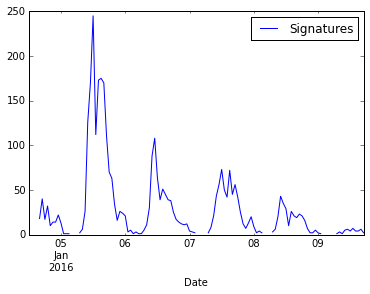

In [16]:
pl = petition.reset_index()[["Signatures","Date"]].set_index("Date").resample("h",how="sum").plot()

## Recoder les différents champs

In [41]:
indic = {
    "c":["chercheuse","chercheur","chercheur/euse"],
    "dr":["directeur de","directrice de","dr ","dr2","dr1","dr2","directeur/trice de recherche"],
    "cr":["chargé de","chargée de","cr1","cr2","chargé(e) de recherche","cr "],
    "mc":["mcf","mcu","de conférence","de conference","maître(sse) de conférence","mdc"],
    "pu":["professeur","professeure","professeur(e) des universités"],
    "i":["ingénieur","ingenieur"],
    "d":["doctorant","phd"]
}

def check(x,l):
    for i in l:
        if i in x:
            return True
    return False

def recod_statut(x):
    x = x.lower()
    if x in ["dr"] or check(x,indic["dr"]):
        return "directeur/rice de recherche"
    if x in ["cr"] or check(x,indic["cr"]):
        return "chargé(e) de recherche"
    if x in ["mc"] or check(x,indic["mc"]):
        return "maître(sse) de conférence"
    if  x in ["pu","pr"] or check(x,indic["pu"]):
        return "professeur(e) des universités"
    if "enseignant" in x and "chercheur" in x:
        return "enseignant(e)-chercheur(e)"
    if check(x,indic["d"]):
        return "doctorant(e)"
    if "post" in x:
        return "post-doc"
    if x in ["ir","ie"] or check(x,indic["i"]):
        return "ingénieur(e)"
    if "technic" in x:
        return "technicien(ne)"
    if check(x,indic["c"]):
        return "chercheur(e)"
    return x

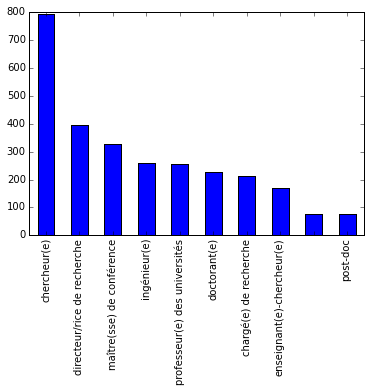

In [42]:
petition["Statut"].apply(lambda x: recod_statut(x)).value_counts()[0:10].plot(kind="bar")

In [39]:
indic = {"un":["université","universite","uni","upmc","lille","lyon 1","amu","uga","toulouse iii","paris-sud","ups","strasbourg"],
         "mn":["mnhn","naturelle"],
         "ens":["ens","ecole normal"]
}

def recod_statut(x):
    x = x.lower()
    if "cnrs" in x:
        return "cnrs"
    if "inserm" in x:
        return "inserm"
    if check(x,indic["un"]):
        return "université"
    if check(x,indic["mn"]):
        return "muséum national d'histoire naturelle "
    if check(x,indic["ens"]):
        return "ens"
    if "pasteur" in x:
        return "institut pasteur"
    if "curie" in x:
        return "institut curie"
    return x

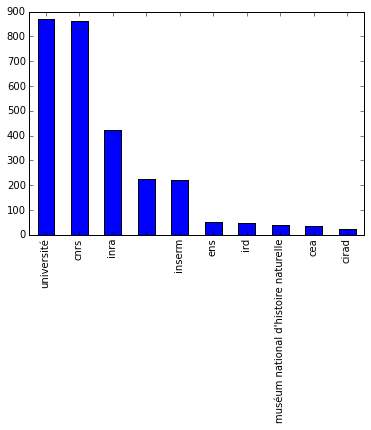

In [40]:
petition["Organisme"].apply(lambda x: recod_statut(x)).value_counts()[0:10].plot(kind="bar")

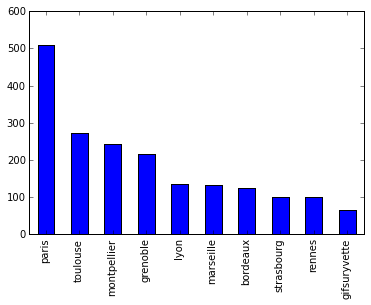

In [43]:
petition["Ville"].apply(lambda x:x.lower().replace(" ","").replace("-","")).value_counts()[0:10].plot(kind="bar")